# Illustration of clustering on Velib data

Author: O. Roustant, INSA Toulouse. December 2020.


We consider the ‘Vélib’ data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). The aim is to detect clusters in the data, corresponding to common customer usages. This clustering should then be used to predict the loading profile. In this notebook, we compare a clustering performed on raw data, in dimension 168, and a clustering done on the PCA coordinates, in dimension 5 or less.

In [2]:
rm(list = ls())

#library(funFEM)
# data(velib)
load("velib.RData")

# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names

# consider a subsample
set.seed(0)
n <- nrow(x)
stations <- sample(1:n, size = n) # if size = n give all the data
coord <- velib$position[stations,]

# select exactly 7 days of data
dates <- 14:181
x <- x[stations, dates]  
colnames(x) <- 1:length(dates)


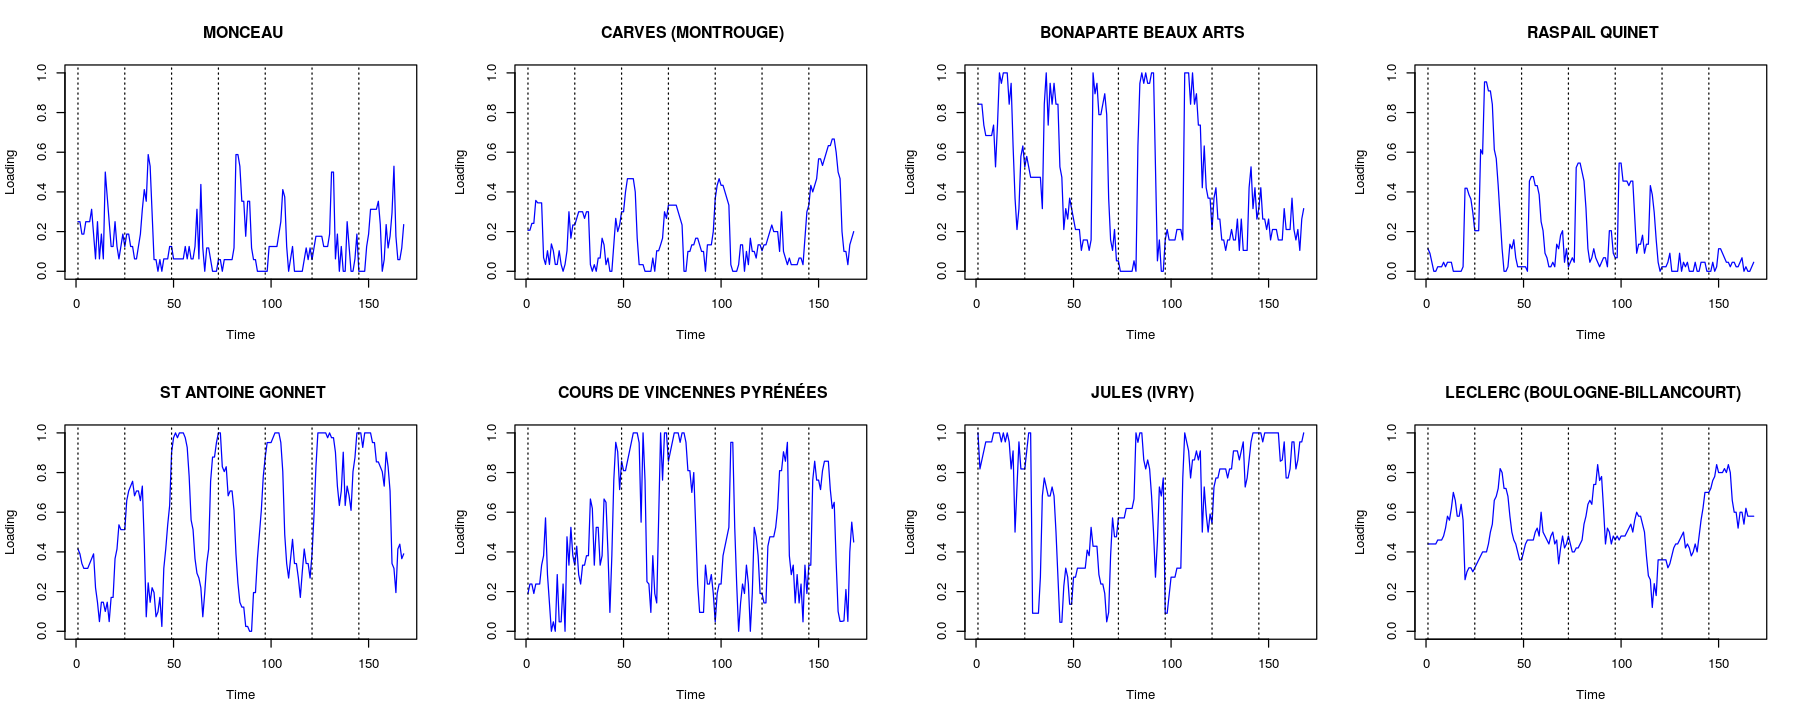

In [3]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
par(mfrow = c(2, 4))
options(repr.plot.width = 15, repr.plot.height = 6)
for (i in 1:8){
  plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = rownames(x)[i])
  abline(v = timeTick, lty = "dotted")
}

In [ ]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
rownames(x) <- 1:nrow(x)

In [ ]:
# Boxplot of the variables, sorted in time order
par(mfrow = c(1, 1))
boxplot(x, xlab = "Time", ylab = "Loading")
abline(v = timeTick, lwd = 2)


### Descriptive statistics.
Look at the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?

### Hierarchical clustering on raw data.

a) Perform hierarchical clustering with Ward criterion. 
Plot the dendrogram and the heights versus the number of classes. 
Number of classes?

b) What can you say of the sizes of the corresponding classes? 
Are there classes with only one individual? 
This could happen with another criterion: which one? Try it.

c) Plot the centers of the clusters. Interpret the results.

In [ ]:
# ?hclust
d <- dist(x)
reshc <- hclust(d, method = "ward.D")
par(mfrow = c(1, 2))
options(repr.plot.width = 12, repr.plot.height = 6)
plot(reshc) 
plot(reshc$height[199:180], xlab = "number of classes", ylab = "height")


### Clustering with k-means.
Perform k-means with the number of classes suggested by hierarchical clustering.

(a) Represent the center of each class as a discrete curve. 
Give the interpretation of the centers of the classes.

(b) Which criterion aims at minimizing k-means? Is the optimum found local or global?

(c) In order to visualize the quality of the clustering, 
represent the boxplots of loading profiles for each time step, and for each class. 
Are the classes homogeneous? Interpret the results in terms 
of within-class variance and global variance.

(d) For this dataset, we have extra information, namely whether the station is located on a hill. To what class(es) does it correspond?

(e) Plot the results on a map, using the station coordinates. In practice, what is missing to interpret the results?


In [ ]:
# ?kmeans
## Center of each class
K <- 7
reskm <- kmeans(x, centers = K)
par(mfrow = c(3, 3))
for (i in 1:K){
  plot(reskm$centers[i, ], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = paste("Center of class", i))
  abline(v = timeTick, lty = "dotted")
}
## Boxplot of loading files, and cluster centers
par(mfrow = c(3, 3))
options(repr.plot.width = 15, repr.plot.height = 12)
for (i in 1:K){
  boxplot(x[which(reskm$cluster==i), ], 
          xlab = "Time", ylab = "Loading", main = paste("Class", i))
  lines(reskm$centers[i, ], col = "blue", lwd = 3)
  abline(v = timeTick, lty = "dotted")
}

In [ ]:
## Help for interpretation, stations on a hill
hillData <- data.frame(class = reskm$cluster, hill = velib$bonus[stations])
table(hillData)

In [ ]:
## Geographical representation 
coord <- velib$position[stations,]
par(mfrow = c(1, 2))
options(repr.plot.width = 12, repr.plot.height = 6)
plot(coord, pch = reskm$cluster, col = reskm$cluster, main = "geographical position")
plot(coord, pch = velib$bonus[stations], col = velib$bonus[stations], main = "stations on a hill")

### Clustering on a reduced basis.
Here it may be a better idea to reduce dimension before doing clustering. 
There are two main solutions, either using a functional basis e.g. Fourier basis (for instance) or doing PCA. Here we illustrate PCA.

(a) Plot the proportion of variance explained by each dimension, as well as the boxplot of coordinates. How many principal components p may we choose?

(b) Interpret the principal components?

(c) Perform a k-means clustering on the p first principal components. Interpret the centers of the class. Compare with the clustering on the raw data.

(d) Visualize the results in the 2D space of the first two PCA coordinates.

In [ ]:
## PCA
library(FactoMineR)
mpca <- PCA(x, scale.unit = TRUE, graph = FALSE, ncp = 15)
par(mfrow = c(1, 2))
options(repr.plot.width = 12, repr.plot.height = 6)
barplot(mpca$eig[1:15, 2], xlab = "Number of components", 
        ylab = "% of variance")
boxplot(mpca$ind$coord, ylim = c(-7, 7),
        xlab = "Number of the principal axis",
        ylab = "Coordinate on the principal axis")

In [ ]:
## Interpretation of principal components
par(mfrow = c(2, 2))
options(repr.plot.width = 12, repr.plot.height = 6)
for (i in 1:4){
  plot(mpca$var$coord[, i], ylim = c(-1, 1), 
       type = "l", col = "blue", 
       ylab = "Loading", xlab = "Time", 
       main = paste("Principal component", i))
  abline(v = timeTick, lty = "dotted")
}
par(mfrow = c(1, 2))
plot(mpca, axes = c(1, 2), choix = "var", cex = 0.5, lwd = 0.5)
plot(mpca, axes = c(1, 2), choix = "ind", cex = 0.5, lwd = 0.5)

In [ ]:
## Clustering on the scores of the principal components
p <- 5  # number of principal components
reskmPCA <- kmeans(mpca$ind$coord[, 1:p], centers = K)   # use the same as previously chosen
reskmPCAcenters <- matrix(nrow = ncol(x), ncol = K)
for (i in 1:K){
    reskmPCAcenters[, i] <- mpca$call$centre + 
    mpca$call$ecart.type * mpca$var$coord[, 1:p] %*% (as.matrix(reskmPCA$centers[i, ], ncol = 1) / sqrt(mpca$eig[1:p, 1])) # coord. in the orig. space
}

par(mfrow = c(3, 3))
for (i in 1:K){
  plot(reskmPCAcenters[, i], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = paste("Center of class", i))
  abline(v = timeTick, lty = "dotted")
}
par(mfrow = c(3, 3))
options(repr.plot.width = 15, repr.plot.height = 12)
for (i in 1:K){
  boxplot(x[which(reskmPCA$cluster==i), ], 
          xlab = "Time", ylab = "Loading", main = paste("Class", i))
  lines(reskmPCAcenters[, i], col = "blue", lwd = 3)
}

In [ ]:
## Comparaison of the two clusterings (on the raw data, or on the PCA scores)
tabCompCluster <-table(reskm$cluster, reskmPCA$cluster)  # seem to correspond up to a permutation
tabCompCluster
clusterPerm <- apply(tabCompCluster, 2, which.max)  # permutation maximizing the diagonal terms
clusterPerm  
table(reskm$cluster, clusterPerm[reskmPCA$cluster])  # should be the closest to a diagonal table

##  
par(mfrow = c(1, 2))
options(repr.plot.width = 12, repr.plot.height = 6)
plot(coord, pch = reskm$cluster, col = reskm$cluster, main = "Clustering on raw data (dim 168)")
plot(coord, pch = clusterPerm[reskmPCA$cluster], col = clusterPerm[reskmPCA$cluster], 
     main = "Clustering on PCA coordinates (dim 5)")

In [ ]:
# Visualization of the results in the 2D space of the first two PCA coordinates
par(mfrow = c(1, 2))
plot(mpca$ind$coord[, 1], mpca$ind$coord[, 2], 
     col = reskm$cluster, pch = reskm$cluster,
     xlab = "First PCA coordinate", ylab = "Second PCA coordinate", 
     main = "Clustering on the raw data")
plot(mpca$ind$coord[, 1], mpca$ind$coord[, 2], 
     col = clusterPerm[reskmPCA$cluster], pch = clusterPerm[reskmPCA$cluster],
     xlab = "First PCA coordinate", ylab = "Second PCA coordinate", 
     main = "Clustering on the PCA coordinates")
